# Adaptive CMA-ES configurations - Analysis

This Python Notebook covers the analysis of pre-processed data for the adaptive CMA-ES research.

The input data consists of CSVs with the required runtimes for each pre-specified target for all runs, separated into files for each function/dimensionality pair. For details on the pre-processing that went into creating this data, please refer to the `pre-processing.ipynb/html` notebook.

An example with target values 100, 1 and 0.01:

`idx |   1   2   3 ...   56   57   58   59 ...    164    165    166    167`<br>
`val | 124 102  94 ... 1.13 1.06 0.98 0.96 ... 0.0123 0.0109 0.0098 0.0097`

For section `$\inf$-100`, the first index where the value is _below_ 100 is 3. For the next target the index is 58, and for the final target the first index is 166.


> Sander van Rijn<br>
> s.j.van.rijn@liacs.leidenuniv.nl<br>
> LIACS<br>
> 2018-03-01

## Initialization

In [1]:
%matplotlib inline

from __future__ import division, print_function

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from collections import Counter

In [2]:
# Some utility functions for dealing with the representations

# First, some hardcoded variables
num_options_per_module = [2]*9        # Binary part
num_options_per_module.extend([3]*2)  # Ternary part
max_length = 11
factors = [2304, 1152, 576, 288, 144, 72, 36, 18, 9, 3, 1]

def list_all_representations():
    """ Create a list of all possible representations for the modular CMA-ES.
        Each representation is itself a list with <max_length> integer entries {0, 1, ..., n},
        where 'n' is the number of options for the module in that position.
    """
    products = []
    # count how often there is a choice of x options
    counts = Counter(num_options_per_module)
    for num, count in sorted(counts.items(), key=lambda x: x[0]):
        products.append(product(range(num), repeat=count))
    all_representations = []
    for representation in list(product(*products)):
        all_representations.append(list(sum(representation, ())))
    return all_representations


def reprToString(representation):
    """ Function that converts the structure parameters of a given ES-structure representation to a string

        >>> reprToInt([0,0,0,0,0,1,0,1,0,1,0])
        >>> '00000101010'
    """
    return ''.join([str(i) for i in representation[:max_length]])

In [3]:
data_location = '/media/rijnsjvan/Data/SurfDrive/Research Data/Adaptive ES/anytime_convergence/data/'
# file_name = 'steepness_data_{ndim}D-f{fid}.csv'
# file_name = 'interpolated_ART_data_{ndim}D-f{fid}.csv'
# file_name = 'stepwise_ERT_data_{ndim}D-f{fid}.csv'
file_name = 'ERT_data_{ndim}D-f{fid}.csv'


#TODO: Retrieve this information from the files instead?
ndims = [5, 20]
fids = [1, 10, 15, 20]

num_steps = 51
powers = np.round(np.linspace(2, -8, num_steps), decimals=1)
target_values = np.power([10]*num_steps, powers)

columns = ['10e{}'.format(power) for power in powers]


np.set_printoptions(linewidth=1000, edgeitems=30)
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', 1000)

# Exploration
Using the data in (one of) the CSV files, we'll start with some exploratory analysis.
Any useful procedures will be coded as functions, making them easy to re-use for a final full analysis later on.

In [4]:
def get_data(ndim, fid):
    return pd.read_csv(data_location + file_name.format(ndim=ndim, fid=fid), index_col=0)

# Starting with 5D F1 as an example
df = get_data(ndim=5, fid=1)
df.head()

,Representation,ndim,function ID,instance ID,repetition,10e2.0,10e1.8,10e1.6,10e1.4,10e1.2,10e1.0,10e0.8,10e0.6,10e0.4,10e0.2,10e0.0,10e-0.2,10e-0.4,10e-0.6,10e-0.8,10e-1.0,10e-1.2,10e-1.4,10e-1.6,10e-1.8,10e-2.0,10e-2.2,10e-2.4,10e-2.6,10e-2.8,10e-3.0,10e-3.2,10e-3.4,10e-3.6,10e-3.8,10e-4.0,10e-4.2,10e-4.4,10e-4.6,10e-4.8,10e-5.0,10e-5.2,10e-5.4,10e-5.6,10e-5.8,10e-6.0,10e-6.2,10e-6.4,10e-6.6,10e-6.8,10e-7.0,10e-7.2,10e-7.4,10e-7.6,10e-7.8,10e-8.0
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,1,0,0,0.0,0.0,1.0,6.0,11.0,102.0,238.0,264.0,271.0,273.0,290.0,325.0,344.0,365.0,368.0,368.0,373.0,417.0,421.0,445.0,469.0,474.0,486.0,497.0,504.0,509.0,511.0,560.0,582.0,601.0,608.0,608.0,608.0,619.0,666.0,673.0,675.0,676.0,677.0,677.0,677.0,696.0,737.0,763.0,785.0,810.0,825.0,831.0,836.0,853.0,888.0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,1,0,1,0.0,0.0,0.0,3.0,17.0,111.0,133.0,147.0,159.0,251.0,310.0,346.0,370.0,478.0,502.0,508.0,524.0,530.0,534.0,536.0,584.0,622.0,632.0,637.0,641.0,680.0,709.0,726.0,728.0,730.0,746.0,783.0,787.0,796.0,799.0,807.0,847.0,854.0,878.0,895.0,901.0,938.0,946.0,951.0,966.0,979.0,981.0,988.0,1023.0,1043.0,1079.0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,1,0,2,0.0,0.0,7.0,17.0,23.0,37.0,70.0,298.0,364.0,374.0,390.0,404.0,415.0,422.0,432.0,456.0,475.0,476.0,492.0,515.0,529.0,539.0,553.0,565.0,584.0,596.0,604.0,620.0,660.0,678.0,685.0,687.0,690.0,696.0,713.0,739.0,750.0,803.0,816.0,839.0,857.0,860.0,861.0,894.0,904.0,918.0,923.0,929.0,936.0,954.0,968.0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,1,0,3,0.0,0.0,0.0,0.0,30.0,34.0,96.0,396.0,420.0,433.0,437.0,442.0,451.0,461.0,485.0,493.0,506.0,515.0,527.0,555.0,599.0,615.0,631.0,640.0,650.0,658.0,692.0,717.0,723.0,728.0,746.0,775.0,785.0,796.0,803.0,816.0,843.0,869.0,900.0,916.0,922.0,926.0,943.0,964.0,981.0,987.0,997.0,1009.0,1026.0,1038.0,1047.0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,1,0,4,0.0,0.0,1.0,15.0,24.0,29.0,32.0,133.0,190.0,201.0,233.0,259.0,272.0,279.0,295.0,307.0,312.0,329.0,347.0,362.0,372.0,393.0,407.0,409.0,410.0,428.0,438.0,442.0,489.0,511.0,516.0,518.0,520.0,544.0,558.0,565.0,614.0,624.0,628.0,630.0,649.0,665.0,676.0,695.0,720.0,740.0,764.0,787.0,788.0,791.0,793.0


In [5]:
def absolutetodifferences(df):
    return_df = df.copy()
    df_columns = list(reversed(columns))
    for column_a, column_b in zip(columns, columns[1:]):
        return_df[column_b] = df[column_b] - df[column_a]
    return return_df

# Next, we get the differences between the running times for each of the targets
df_diff = absolutetodifferences(df)
df_diff.head()

,Representation,ndim,function ID,instance ID,repetition,10e2.0,10e1.8,10e1.6,10e1.4,10e1.2,10e1.0,10e0.8,10e0.6,10e0.4,10e0.2,10e0.0,10e-0.2,10e-0.4,10e-0.6,10e-0.8,10e-1.0,10e-1.2,10e-1.4,10e-1.6,10e-1.8,10e-2.0,10e-2.2,10e-2.4,10e-2.6,10e-2.8,10e-3.0,10e-3.2,10e-3.4,10e-3.6,10e-3.8,10e-4.0,10e-4.2,10e-4.4,10e-4.6,10e-4.8,10e-5.0,10e-5.2,10e-5.4,10e-5.6,10e-5.8,10e-6.0,10e-6.2,10e-6.4,10e-6.6,10e-6.8,10e-7.0,10e-7.2,10e-7.4,10e-7.6,10e-7.8,10e-8.0
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,1,0,0,0.0,0.0,1.0,5.0,5.0,91.0,136.0,26.0,7.0,2.0,17.0,35.0,19.0,21.0,3.0,0.0,5.0,44.0,4.0,24.0,24.0,5.0,12.0,11.0,7.0,5.0,2.0,49.0,22.0,19.0,7.0,0.0,0.0,11.0,47.0,7.0,2.0,1.0,1.0,0.0,0.0,19.0,41.0,26.0,22.0,25.0,15.0,6.0,5.0,17.0,35.0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,1,0,1,0.0,0.0,0.0,3.0,14.0,94.0,22.0,14.0,12.0,92.0,59.0,36.0,24.0,108.0,24.0,6.0,16.0,6.0,4.0,2.0,48.0,38.0,10.0,5.0,4.0,39.0,29.0,17.0,2.0,2.0,16.0,37.0,4.0,9.0,3.0,8.0,40.0,7.0,24.0,17.0,6.0,37.0,8.0,5.0,15.0,13.0,2.0,7.0,35.0,20.0,36.0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,1,0,2,0.0,0.0,7.0,10.0,6.0,14.0,33.0,228.0,66.0,10.0,16.0,14.0,11.0,7.0,10.0,24.0,19.0,1.0,16.0,23.0,14.0,10.0,14.0,12.0,19.0,12.0,8.0,16.0,40.0,18.0,7.0,2.0,3.0,6.0,17.0,26.0,11.0,53.0,13.0,23.0,18.0,3.0,1.0,33.0,10.0,14.0,5.0,6.0,7.0,18.0,14.0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,1,0,3,0.0,0.0,0.0,0.0,30.0,4.0,62.0,300.0,24.0,13.0,4.0,5.0,9.0,10.0,24.0,8.0,13.0,9.0,12.0,28.0,44.0,16.0,16.0,9.0,10.0,8.0,34.0,25.0,6.0,5.0,18.0,29.0,10.0,11.0,7.0,13.0,27.0,26.0,31.0,16.0,6.0,4.0,17.0,21.0,17.0,6.0,10.0,12.0,17.0,12.0,9.0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,1,0,4,0.0,0.0,1.0,14.0,9.0,5.0,3.0,101.0,57.0,11.0,32.0,26.0,13.0,7.0,16.0,12.0,5.0,17.0,18.0,15.0,10.0,21.0,14.0,2.0,1.0,18.0,10.0,4.0,47.0,22.0,5.0,2.0,2.0,24.0,14.0,7.0,49.0,10.0,4.0,2.0,19.0,16.0,11.0,19.0,25.0,20.0,24.0,23.0,1.0,3.0,2.0


We can already see a problem here: Some of the smallest values are zeroes.
This means that the actual improvement step made by the algorithm went across the specified targets.

In [6]:
print(df_diff[columns].min(axis=0))

10e2.0     0.0
10e1.8     0.0
10e1.6     0.0
10e1.4     0.0
10e1.2     0.0
10e1.0     0.0
10e0.8     0.0
10e0.6     0.0
10e0.4     0.0
10e0.2     0.0
10e0.0     0.0
10e-0.2    0.0
10e-0.4    0.0
10e-0.6    0.0
10e-0.8    0.0
10e-1.0    0.0
10e-1.2    0.0
10e-1.4    0.0
10e-1.6    0.0
10e-1.8    0.0
10e-2.0    0.0
10e-2.2    0.0
10e-2.4    0.0
10e-2.6    0.0
10e-2.8    0.0
10e-3.0    0.0
10e-3.2    0.0
10e-3.4    0.0
10e-3.6    0.0
10e-3.8    0.0
10e-4.0    0.0
10e-4.2    0.0
10e-4.4    0.0
10e-4.6    0.0
10e-4.8    0.0
10e-5.0    0.0
10e-5.2    0.0
10e-5.4    0.0
10e-5.6    0.0
10e-5.8    0.0
10e-6.0    0.0
10e-6.2    0.0
10e-6.4    0.0
10e-6.6    0.0
10e-6.8    0.0
10e-7.0    0.0
10e-7.2    0.0
10e-7.4    0.0
10e-7.6    0.0
10e-7.8    0.0
10e-8.0    0.0
dtype: float64


In [7]:
def aggregateByMean(df):
    df_means = df.groupby(by=['Representation', 'ndim', 'function ID']).mean(numeric_only=True)
    df_means = df_means.drop(columns=['instance ID', 'repetition'])
    df_means = df_means.reset_index()
    return df_means

def aggregateByStd(df):
    df_std = df.groupby(by=['Representation', 'ndim', 'function ID']).std()
    df_std = df_std.drop(columns=['instance ID', 'repetition'])
    df_std = df_std.reset_index()
    return df_std

def aggregateByMax(df):
    df_means = df.groupby(by=['Representation', 'ndim', 'function ID']).max(axis=1)
    df_means = df_means.drop(columns=['instance ID', 'repetition'])
    df_means = df_means.reset_index()
    return df_means

def aggregateByMedian(df):
    df_means = df.groupby(by=['Representation', 'ndim', 'function ID']).median(numeric_only=True)
    df_means = df_means.drop(columns=['instance ID', 'repetition'])
    df_means = df_means.reset_index()
    return df_means

def aggregateBy(df, aggregation):
    if aggregation == 'mean':
        return aggregateByMean(df)
    elif aggregation == 'std':
        return aggregateByStd(df)
    elif aggregation == 'max':
        return aggregateByMax(df)
    elif aggregation == 'median':
        return aggregateByMedian(df)
    else:
        raise ValueError("Invalid choice for 'aggregation': {aggregation}")

In [8]:
# Then we can aggregate
df_diff = aggregateByMax(absolutetodifferences(df))
df_diff.head()

,Representation,ndim,function ID,10e2.0,10e1.8,10e1.6,10e1.4,10e1.2,10e1.0,10e0.8,10e0.6,10e0.4,10e0.2,10e0.0,10e-0.2,10e-0.4,10e-0.6,10e-0.8,10e-1.0,10e-1.2,10e-1.4,10e-1.6,10e-1.8,10e-2.0,10e-2.2,10e-2.4,10e-2.6,10e-2.8,10e-3.0,10e-3.2,10e-3.4,10e-3.6,10e-3.8,10e-4.0,10e-4.2,10e-4.4,10e-4.6,10e-4.8,10e-5.0,10e-5.2,10e-5.4,10e-5.6,10e-5.8,10e-6.0,10e-6.2,10e-6.4,10e-6.6,10e-6.8,10e-7.0,10e-7.2,10e-7.4,10e-7.6,10e-7.8,10e-8.0
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,1,5.0,8.0,7.0,16.0,30.0,201.0,249.0,300.0,309.0,347.0,90.0,45.0,49.0,108.0,52.0,24.0,27.0,44.0,36.0,63.0,74.0,38.0,54.0,69.0,43.0,96.0,54.0,49.0,47.0,47.0,39.0,42.0,33.0,35.0,47.0,37.0,62.0,53.0,42.0,55.0,30.0,39.0,41.0,56.0,49.0,51.0,36.0,42.0,37.0,29.0,74.0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",5,1,5.0,10.0,16.0,27.0,138.0,196.0,252.0,332.0,110.0,282.0,95.0,60.0,36.0,27.0,58.0,79.0,60.0,43.0,33.0,40.0,50.0,44.0,97.0,62.0,55.0,40.0,37.0,34.0,44.0,57.0,38.0,31.0,57.0,64.0,59.0,45.0,56.0,57.0,46.0,41.0,79.0,49.0,59.0,39.0,40.0,99.0,53.0,28.0,51.0,38.0,33.0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]",5,1,2.0,11.0,8.0,23.0,46.0,232.0,327.0,233.0,219.0,104.0,297.0,69.0,51.0,43.0,41.0,83.0,68.0,32.0,44.0,40.0,41.0,42.0,55.0,44.0,57.0,57.0,46.0,46.0,47.0,85.0,50.0,61.0,80.0,68.0,55.0,49.0,31.0,48.0,27.0,28.0,37.0,41.0,60.0,68.0,30.0,62.0,53.0,42.0,44.0,56.0,53.0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",5,1,1.0,22.0,16.0,27.0,51.0,86.0,164.0,265.0,344.0,97.0,62.0,51.0,55.0,60.0,42.0,39.0,38.0,39.0,70.0,28.0,30.0,60.0,51.0,38.0,34.0,37.0,30.0,54.0,45.0,42.0,55.0,79.0,79.0,40.0,102.0,28.0,39.0,31.0,44.0,18.0,47.0,74.0,30.0,38.0,44.0,99.0,44.0,57.0,27.0,42.0,37.0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]",5,1,1.0,9.0,9.0,20.0,46.0,170.0,177.0,309.0,124.0,89.0,46.0,136.0,70.0,54.0,44.0,43.0,52.0,31.0,19.0,31.0,46.0,51.0,32.0,50.0,50.0,44.0,43.0,35.0,34.0,36.0,50.0,38.0,49.0,44.0,33.0,48.0,58.0,22.0,54.0,68.0,31.0,52.0,30.0,63.0,28.0,45.0,66.0,37.0,52.0,41.0,41.0


If we aggregate before calculating the differences, we can end up disrupting the monotonically decreasing nature of our data. This would result in a negative difference score!

Instead, by first calculating the differences, we can then aggregate over the actually existing differences

In [9]:
section_labels = ['\inf - 10e{}'.format(powers[0])]
section_labels.extend(['10e{} - 10e{}'.format(a, b) for a, b in zip(powers[:-1], powers[1:])])

def plotOnAxis(df, columns, ax, *, title=None, legend=True):
    for idx, row in df.iterrows():
        ax.plot(row[columns].values, '-', label=row['Representation'])

    ax.set_ylabel("\'steepness\'")
    ax.set_xlabel('convergence sections')
    ax.set_xticks(np.arange(len(target_values)))
    ax.set_xticklabels(section_labels)
    ax.xaxis.set_tick_params(rotation=90)
    if title:
        ax.set_title(title)
    if legend:
        ax.legend(loc=0)

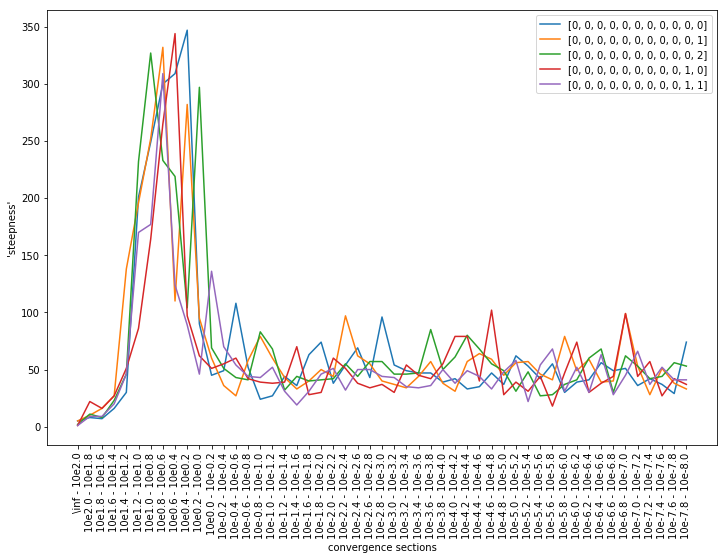

In [10]:
# Let's plot the head (=first 5 rows) of the currently loaded data as an example
fig, ax = plt.subplots(figsize=(12,8))
plotOnAxis(df_diff.head(), columns, ax)
plt.show()

In [11]:
# Extracting only the configurations that are best between a pair of targets rather than all 4,608...
def selectSmallestPerColumn(df, columns, nsmallest=1):
    indices = set()
    for col in columns:
        if df[col].max() > 0:
            new_indices = set(df[col].nsmallest(nsmallest).axes[0])
            indices = indices.union(new_indices)
    return df.iloc[sorted(indices)]

selectSmallestPerColumn(df_diff, columns).head()

,Representation,ndim,function ID,10e2.0,10e1.8,10e1.6,10e1.4,10e1.2,10e1.0,10e0.8,10e0.6,10e0.4,10e0.2,10e0.0,10e-0.2,10e-0.4,10e-0.6,10e-0.8,10e-1.0,10e-1.2,10e-1.4,10e-1.6,10e-1.8,10e-2.0,10e-2.2,10e-2.4,10e-2.6,10e-2.8,10e-3.0,10e-3.2,10e-3.4,10e-3.6,10e-3.8,10e-4.0,10e-4.2,10e-4.4,10e-4.6,10e-4.8,10e-5.0,10e-5.2,10e-5.4,10e-5.6,10e-5.8,10e-6.0,10e-6.2,10e-6.4,10e-6.6,10e-6.8,10e-7.0,10e-7.2,10e-7.4,10e-7.6,10e-7.8,10e-8.0
34,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1]",5,1,0.0,12.0,8.0,25.0,71.0,151.0,166.0,357.0,160.0,165.0,271.0,53.0,59.0,57.0,69.0,51.0,49.0,43.0,46.0,36.0,68.0,29.0,38.0,29.0,54.0,54.0,79.0,57.0,30.0,74.0,42.0,37.0,66.0,51.0,29.0,31.0,77.0,44.0,41.0,56.0,32.0,42.0,47.0,42.0,64.0,32.0,53.0,41.0,53.0,85.0,39.0
86,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2]",5,1,2.0,1.0,16.0,16.0,35.0,418.0,300.0,1545.0,3519.0,9191.0,18506.0,26345.0,25117.0,36553.0,11342.0,2646.0,100.0,43.0,55.0,43.0,51.0,27.0,36.0,5.0,36.0,13.0,3.0,29.0,34.0,22.0,13.0,14.0,8.0,7.0,12.0,5.0,1.0,34.0,22.0,14.0,9.0,32.0,23.0,4.0,7.0,16.0,2.0,12.0,22.0,14.0,12.0
89,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2]",5,1,2.0,3.0,6.0,16.0,98.0,130.0,274.0,1113.0,3820.0,14815.0,32255.0,42746.0,18730.0,37088.0,6393.0,1566.0,91.0,62.0,74.0,25.0,35.0,20.0,39.0,103.0,24.0,26.0,26.0,28.0,45.0,42.0,5.0,65.0,19.0,34.0,43.0,25.0,22.0,23.0,15.0,18.0,33.0,31.0,10.0,30.0,38.0,1.0,11.0,49.0,15.0,27.0,14.0
414,"[0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0]",5,1,3.0,7.0,22.0,5.0,13.0,48.0,16.0,75.0,35.0,44.0,71.0,68.0,82.0,40.0,24.0,30.0,62.0,145.0,92.0,85.0,103.0,82.0,55.0,34.0,40.0,58.0,39.0,42.0,40.0,61.0,73.0,64.0,85.0,52.0,76.0,47.0,68.0,51.0,67.0,32.0,68.0,41.0,117.0,70.0,103.0,48.0,49.0,61.0,76.0,48.0,54.0
646,"[0, 0, 1, 0, 0, 0, 1, 1, 1, 2, 1]",5,1,1.0,18.0,18.0,20.0,17.0,18.0,9.0,59.0,35.0,65.0,39.0,58.0,42.0,51.0,27.0,33.0,61.0,53.0,42.0,53.0,39.0,48.0,28.0,36.0,75.0,28.0,26.0,22.0,76.0,31.0,55.0,42.0,93.0,61.0,51.0,69.0,32.0,49.0,84.0,55.0,41.0,60.0,74.0,44.0,70.0,102.0,47.0,41.0,54.0,149.0,49.0


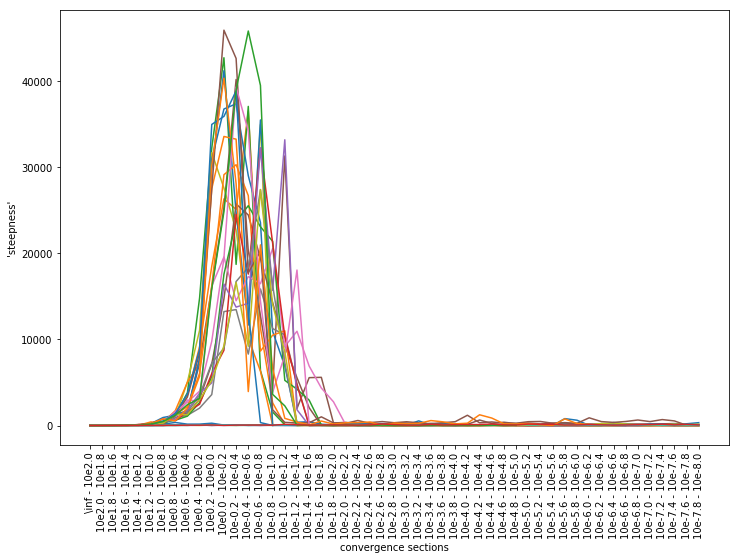

In [12]:
# Now we plot all differences for each configuration that is best between at least one pair of targets
subset = selectSmallestPerColumn(df_diff, columns)
fig, ax = plt.subplots(figsize=(12,8))
plotOnAxis(subset, columns, ax, legend=False)
plt.show()

We get some really large values here, which are actually not what we want to see: higher values mean bad performance.

Instead, at least to visualize, it's more interesting to look at the 1/$\delta$'s.

In [13]:
def makecleaninverses(df, columns):
    return_df = df.copy()
    for col in columns:
        return_df[col] = 1/df[col]
    return_df = return_df.replace(np.inf, np.NaN)
    return return_df

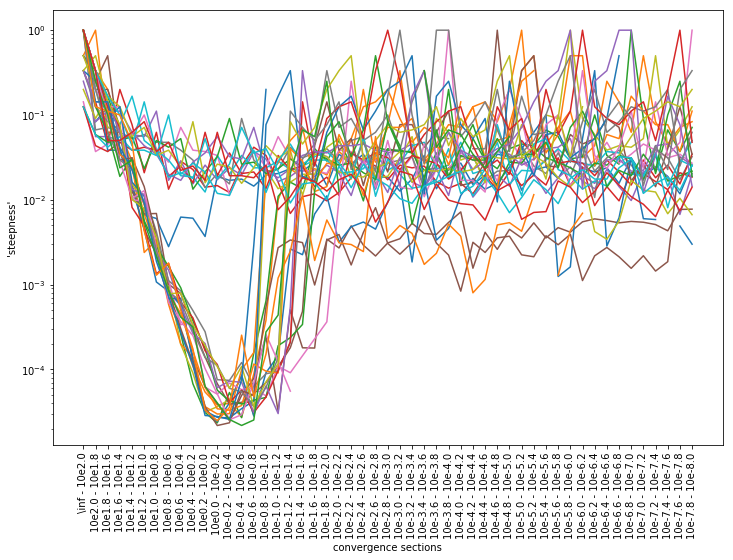

In [14]:
# Now we plot all differences for each configuration that is best between at least one pair of targets
subset = makecleaninverses(selectSmallestPerColumn(df_diff, columns), columns)
fig, ax = plt.subplots(figsize=(12,8))
plotOnAxis(subset, columns, ax, legend=False)
plt.yscale('log')
plt.show()

In [15]:
#SOME DEBUGGING INFO
# idx = df_diff[columns[14]].nsmallest(1).axes[0]
# print(idx)
# rep = df_diff.iloc[idx]['Representation'].values[0]
# print(rep)

# subset = df[df['Representation'] == rep]

# print(idx)
# print(subset.as_matrix(columns).astype(int))
# print(df_diff.iloc[idx].as_matrix(columns))

#SOME DEBUGGING INFO
# print(absolutetodifferences(aggregateByMean(subset)).as_matrix(columns).astype(int))

# Analysis of all experiments

In [16]:
# Just some caching
full_data = {(ndim, fid): get_data(ndim=ndim, fid=fid) for ndim, fid in product(ndims, fids)}

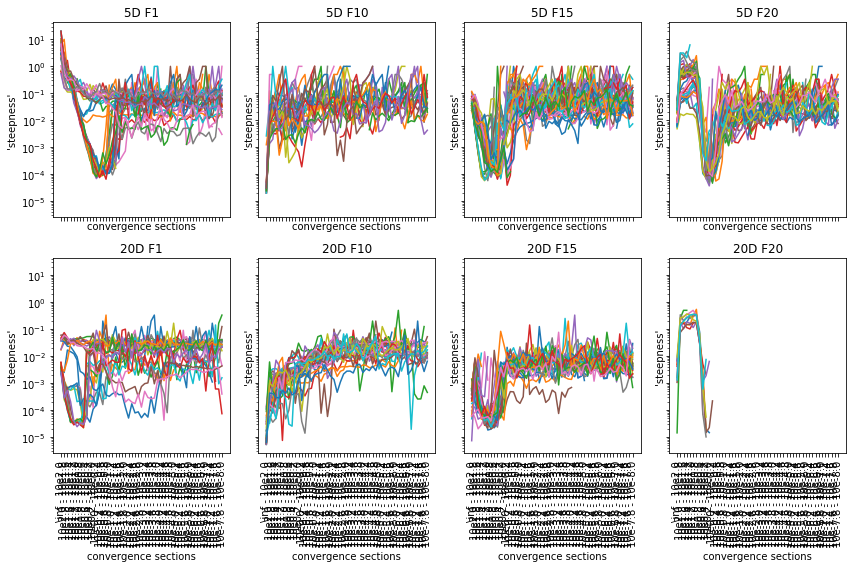

In [17]:
# Because it's defined as a simple-to-use function, we can now plot this data for all available datasets
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(12,8), sharex=True, sharey=True)

for exp, ax in zip(product(ndims, fids), axes.flatten()):
    ndim, fid = exp
    df_means = aggregateByMean(absolutetodifferences(full_data[(ndim, fid)]))
    subset = makecleaninverses(selectSmallestPerColumn(df_means, columns), columns)
    plotOnAxis(subset, columns, ax, title='{}D F{}'.format(ndim, fid), legend=False)
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [18]:
df_diff = absolutetodifferences(get_data(ndim=5, fid=1))
df_diff[columns] = df_diff[columns].replace(0, np.NaN)  # we replace 0 by NaN so they're automatically excluded
df_diff = aggregateByMax(df_diff)
subset = selectSmallestPerColumn(df_diff, columns)

# And now the hypothetical result if we take the best sub-result per section...
print(subset[columns].min(axis=0))
print(subset[columns].min(axis=0).sum())

10e2.0      1.0
10e1.8      1.0
10e1.6      2.0
10e1.4      5.0
10e1.2      6.0
10e1.0      7.0
10e0.8      9.0
10e0.6     10.0
10e0.4     14.0
10e0.2     12.0
10e0.0     16.0
10e-0.2    16.0
10e-0.4    11.0
10e-0.6    11.0
10e-0.8    14.0
10e-1.0     5.0
10e-1.2     6.0
10e-1.4     3.0
10e-1.6     1.0
10e-1.8     1.0
10e-2.0     3.0
10e-2.2     1.0
10e-2.4     1.0
10e-2.6     5.0
10e-2.8     2.0
10e-3.0     1.0
10e-3.2     1.0
10e-3.4     2.0
10e-3.6     3.0
10e-3.8     1.0
10e-4.0     1.0
10e-4.2     4.0
10e-4.4     6.0
10e-4.6     7.0
10e-4.8     1.0
10e-5.0     2.0
10e-5.2     1.0
10e-5.4     2.0
10e-5.6     1.0
10e-5.8     3.0
10e-6.0     1.0
10e-6.2     1.0
10e-6.4     3.0
10e-6.6     3.0
10e-6.8     1.0
10e-7.0     1.0
10e-7.2     2.0
10e-7.4     2.0
10e-7.6     2.0
10e-7.8     1.0
10e-8.0     1.0
dtype: float64
217.0


In [19]:
def findlastreachedcolumn(df, columns):
    actual_best = np.NaN
    col_idx = 0
    while np.isnan(actual_best):
        col_idx += 1
        actual_best = df[columns[-col_idx]].min()

    return columns[-col_idx]


def calcresults():
    records = []
    labels = ['ndim', 'fid', 'Target', 'Empirical best', 'Adaptive best', 'Relative improvement']
    for ndim, fid in product(ndims, fids):
        df = full_data[(ndim, fid)]

        df_means = aggregateByMean(df)
        last_column = findlastreachedcolumn(df_means, columns)
        actual_best = df_means[last_column].min()

        df_diff = absolutetodifferences(df)
        df_diff[columns] = df_diff[columns].replace(0, np.NaN)
        df_diff = aggregateByMax(df_diff)
        subset = selectSmallestPerColumn(df_diff, columns)
        theory_best = subset[columns].min(axis=0).sum()

        rel_improvement = 1-(theory_best/actual_best)

        records.append((ndim, fid, last_column, actual_best, theory_best, rel_improvement))

    results = pd.DataFrame.from_records(records, columns=labels)
    return results

print(calcresults())

   ndim  fid   Target  Empirical best  Adaptive best  Relative improvement
0     5    1  10e-8.0          412.00          217.0              0.473301
1     5   10  10e-8.0         1437.08          744.0              0.482284
2     5   15  10e-8.0          746.00          542.0              0.273458
3     5   20  10e-8.0          620.00          309.0              0.501613
4    20    1  10e-8.0         1269.05          860.0              0.322328
5    20   10  10e-8.0        16565.48        10995.0              0.336270
6    20   15  10e-8.0        50177.00         3185.0              0.936525
7    20   20  10e-0.2        11321.00         5459.0              0.517799


In [20]:
file_name = 'steepness_data_{ndim}D-f{fid}.csv'  # Using different files
old_full_data = full_data
full_data = full_data = {(ndim, fid): get_data(ndim=ndim, fid=fid) for ndim, fid in product(ndims, fids)}

print(calcresults())

file_name = 'interpolated_ART_data_{ndim}D-f{fid}.csv'  # resetting the variable...
full_data = old_full_data

   ndim  fid   Target  Empirical best  Adaptive best  Relative improvement
0     5    1  10e-8.0          414.35          205.0              0.505249
1     5   10  10e-8.0         1440.92          772.0              0.464231
2     5   15  10e-8.0          750.00          519.0              0.308000
3     5   20  10e-8.0          623.00          284.0              0.544141
4    20    1  10e-8.0         1275.75          671.0              0.474035
5    20   10  10e-8.0        16571.56        10614.0              0.359505
6    20   15  10e-8.0        50189.00         1941.0              0.961326
7    20   20  10e-0.2        11342.00         4041.0              0.643714


# Alternative approach: Limited splits

So far we've looked at finding the optimal performance when you can pick the best convergence in between each pair of targets. Practically, this is not really feasible as you would need to make sure when exactly you are switching, which is very difficult in a black-box setting.

But, as we've seen that there are (significant) gains to be made, so let's scale it down. Instead of allowing arbitrary switching, what happens if we allow only a few switches?

In [21]:
def determinebestsplit(df, columns, *, numsplits=1, aggregation='mean'):
    best_split_idx = 0
    best_value = np.inf
    final_column_idx = columns.index(findlastreachedcolumn(df, columns))

    for split in range(1,final_column_idx):

        part1 = df[df.columns[:5]]
        part1 = part1.assign(values=(df[columns[split]] - df[columns[0]]))
        part1 = aggregateBy(part1, aggregation)

        part2 = df[df.columns[:5]]
        part2 = part2.assign(values=(df[columns[final_column_idx]] - df[columns[split]]))
        part2 = aggregateBy(part2, aggregation)
        
        
        part1 = part1.replace([0, np.NaN], np.inf)
        part1_idx = part1['values'].idxmin()
        val1 = part1.iloc[part1_idx]['values']

        part2 = part2.replace([0, np.NaN], np.inf)
        part2_idx = part2['values'].idxmin()
        val2 = part2.iloc[part2_idx]['values']

        if val1+val2 < best_value:
            best_value = val1+val2
            best_split_idx = split
    
    return best_value, best_split_idx, part1_idx, part2_idx


def calculatesplitbasedrecord(df, aggregation='mean'):
    value, split_idx, part1_idx, part2_idx = determinebestsplit(df, columns, aggregation=aggregation)

    df_aggregated = aggregateBy(df, aggregation=aggregation)
    last_column = findlastreachedcolumn(df_aggregated, columns)
    actual_best_idx = df_aggregated[last_column].idxmin()
    actual_best_value = df_aggregated.iloc[actual_best_idx][last_column]
    
    return (actual_best_value, value, 1-(value/actual_best_value), 
            columns[split_idx], actual_best_idx, part1_idx, part2_idx)


def calculatesplitbasedoverview(cases, *, aggregation='mean'):
    records = []
    for ndim, fid in cases:
        df = full_data[(ndim, fid)]
        record = calculatesplitbasedrecord(df, aggregation=aggregation)
        records.append((ndim, fid, *record))

    labels = ['ndim', 'fid', 'best normal', 'best with split', 'relative improvement', 
              'split', 'best normal index', 'part1 index', 'part2 index']
    results = pd.DataFrame.from_records(records, columns=labels)
    return results

In [22]:
mean_split_overview = calculatesplitbasedoverview(product(ndims, fids))
print(mean_split_overview)

   ndim  fid  best normal  best with split  relative improvement    split  best normal index  part1 index  part2 index
0     5    1       412.00           383.50              0.069175  10e-2.2                921          921         2406
1     5   10      1437.08           476.52              0.668411  10e-1.4               3572          259          377
2     5   15       746.00           526.00              0.294906   10e0.4               4515         4515         1264
3     5   20       620.00           423.00              0.317742  10e-1.2               3506         3506          345
4    20    1      1269.05          1202.70              0.052283  10e-7.6                979          979         2384
5    20   10     16565.48          5210.68              0.685450  10e-1.0                147         2432          221
6    20   15     50177.00          6994.00              0.860613   10e1.0               3028          661         2020
7    20   20     11321.00          4924.00      

In [23]:
max_split_overview = calculatesplitbasedoverview(product(ndims, fids), aggregation='max')
print(max_split_overview)

   ndim  fid  best normal  best with split  relative improvement    split  best normal index  part1 index  part2 index
0     5    1        490.0            456.0              0.069388  10e-6.8                906          906         2406
1     5   10       1857.0            509.0              0.725902  10e-1.6               1266         4146          377
2     5   15        746.0            526.0              0.294906   10e0.4               4515         4515           81
3     5   20        620.0            423.0              0.317742  10e-1.2               3506         3506          345
4    20    1       1437.0           1383.0              0.037578  10e-7.6                978          980         2384
5    20   10      17610.0           5408.0              0.692902  10e-2.0                436         2432          221
6    20   15      50177.0           6994.0              0.860613   10e1.0               3028          661         2020
7    20   20      11321.0           4924.0      

## Convergence plots

What follows are a some plots of convergence behavior:
 * 1) the best original configuration
 * 2) the (entire) configuration that performs best **before** the split (**part1**)
 * 3) the (entire) configuration that performs best **after** the split (**part2**)
 * 4) the **compound** performance of **part1** before the split and **part2** after the split
 
NOTE:
The plots currently only give an indication of what we would like to see. Until the vertical line (i.e., the split location), the compound line follows the convergence of ***part1***, and follows the behavior of ***part2*** after the split. 

For now, the results are not what we would expect, as the red line (compound) should always result in reaching the furthest target with the lowest hitting time. The reason for this, is that these results are (for now) plotted using the mean-aggregated hitting time data, which has the problem that monotonicity is not maintained, while the **calculations** are done on the differences. This still has to be changed.

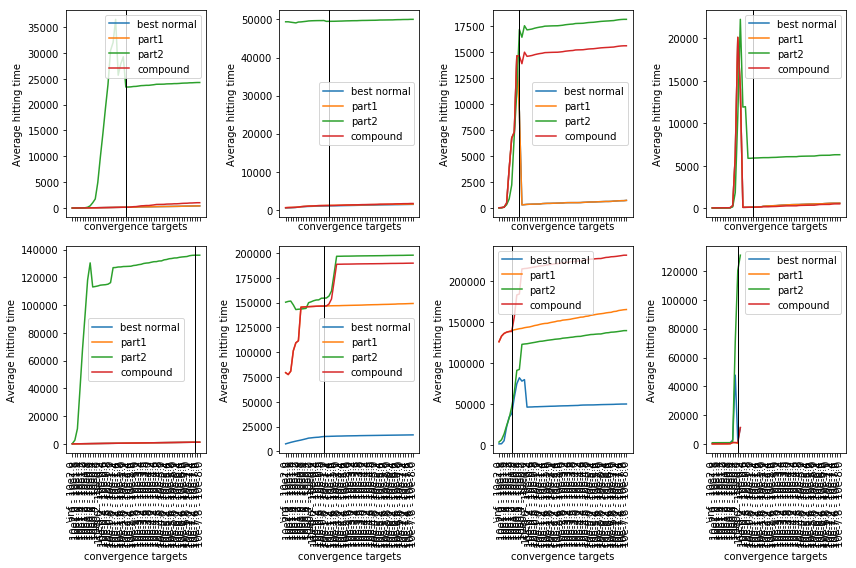

In [24]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(12,8), sharex=True)
    
cases = list(zip(product(ndims, fids), axes.flatten()))
    
for idx, row in mean_split_overview.iterrows():
    
    exp, ax = cases[idx]
    
    ndim, fid = exp
    df = aggregateByMean(full_data[(ndim, fid)])
    
    for column in ['best normal index', 'part1 index', 'part2 index']:
        orig_idx = int(row.loc[column])
        ax.plot(df.iloc[orig_idx][columns].values, '-', label=column[:-6])

    split_idx = columns.index(row.loc['split'])
    part1 = df.iloc[row.loc['part1 index']][columns[:split_idx]].values
    part2 = df.iloc[row.loc['part2 index']][columns[split_idx:]].values
    part2 = (part2 - part2[0]) + part1[-1]
    compound = np.concatenate((part1, part2))
    ax.plot(compound, '-', label='compound')
    
    ax.axvline(split_idx, linewidth=1, color='black')
        

    ax.set_ylabel("Average hitting time")
    ax.set_xlabel('convergence targets')
    ax.set_xticks(np.arange(len(target_values)))
    ax.set_xticklabels(section_labels)
    ax.xaxis.set_tick_params(rotation=90)
#     if title:
#         ax.set_title(title)
#     if legend:
    ax.legend(loc=0)
#     ax.set_yscale('log')

plt.tight_layout()
plt.show()